In [1]:
using Random, JuMP, Ipopt, LinearAlgebra, SparseArrays, DifferentialEquations, Plots, Sundials, LaTeXStrings 
Random.seed!(1)

# Solving: min 1/2 x' * Q * x + c' * x, s.t. Ax>= b, x>=0
n = 5
m = 2
cr = 1e3 # conditioning number
U = qr(rand(n,n)).Q
Q = U*Diagonal(rand(1:cr,n))*U'
c = -10.0.+ 20.0*rand(n)
A = 10.0*rand(m,n)
b = 10.0*rand(m);

# using Ipopt to solve the Problem
Prob = Model(Ipopt.Optimizer)
@variable(Prob, x[1:n]>=0.0)
@objective(Prob, Min, 0.5*x'*Q*x+c'*x)
@constraint(Prob, A*x .>= b)
optimize!(Prob)
status = termination_status(Prob)
println("Solver status: ", status)
x_opt = [value(x[i]) for i in 1:n]


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       10
Number of nonzeros in Lagrangian Hessian.............:       15

Total number of variables............................:        5
                     variables with only lower bounds:        5
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

5-element Vector{Float64}:
 0.5217399773415877
 0.29828241932457483
 0.6330560637045951
 0.5074777269228973
 0.052483559146125285

In [2]:
function Homogeneous_massfun(z,Q,c,A,b,n,m)
    x = z[1:n]
    y = z[n+1:n+m]
    tau = z[n+m+1]
    s = z[n+m+1+1:n+m+1+n]
    v = z[n+m+1+n+1:n+m+1+n+m]
    kappa = z[n+m+1+n+m+1]
    nabla_psi = [Q -A' c;
                 A zeros(m,m) -b;
                -2/tau*x'*Q-c' b' x'*Q*x/tau^2]
    M = [nabla_psi -Diagonal(ones(n+m+1));
         Diagonal([s;v;kappa]) Diagonal([x;y;tau])]
    return M
end

function Homogeneous_odefun(z,Q,c,A,b,n,m,k)
    x = z[1:n]
    y = z[n+1:n+m]
    tau = z[n+m+1]
    s = z[n+m+1+1:n+m+1+n]
    v = z[n+m+1+n+1:n+m+1+n+m]
    kappa = z[n+m+1+n+m+1]
    temp = [Q*x-A'*y+tau*c-s;
            A*x-tau*b-v;
            -1/tau*x'*Q*x-x'*c+y'*b-kappa;
            x.*s;
            y.*v;
            tau*kappa]
    dzdt = -k*(1/norm(temp)+norm(temp))*temp
    return dzdt
end

function Homogeneous_ode!(residual, dz, z, p, t)
    Q, c, A, b, n, m, k = p
    residual .= Homogeneous_massfun(z,Q,c,A,b,n,m) * dz - Homogeneous_odefun(z,Q,c,A,b,n,m,k)
end

Homogeneous_ode! (generic function with 1 method)

In [3]:
Tp = [1.0,0.8,0.6,0.4,0.2,0.1]

k_1 = 2*pi/(4.0*Tp[1])
k_2 = 2*pi/(4.0*Tp[2])
k_3 = 2*pi/(4.0*Tp[3])
k_4 = 2*pi/(4.0*Tp[4])
k_5 = 2*pi/(4.0*Tp[5])
k_6 = 2*pi/(4.0*Tp[6])

Tmax_1 = 0.9999*Tp[1]
Tmax_2 = 0.9999*Tp[2]
Tmax_3 = 0.9999*Tp[3]
Tmax_4 = 0.9999*Tp[4]
Tmax_5 = 0.9999*Tp[5]
Tmax_6 = 0.9999*Tp[6]

p_1 = (Q,c,A,b,n,m,k_1)
p_2 = (Q,c,A,b,n,m,k_2)
p_3 = (Q,c,A,b,n,m,k_3)
p_4 = (Q,c,A,b,n,m,k_4)
p_5 = (Q,c,A,b,n,m,k_5)
p_6 = (Q,c,A,b,n,m,k_6)

z0 = 5*ones(2*(n+m+1))
dz0 = zeros(2*(n+m+1))
tspan = (0.0, Tmax_1)
differential_vars = [true for _ in 1:2*(n+m+1)]
Homogeneous_prob = DAEProblem(Homogeneous_ode!, dz0, z0, tspan, p_1, differential_vars = differential_vars)
t_points = range(tspan[1],tspan[2],length=10000)
# sol_1 = solve(Homogeneous_prob, IDA(), saveat=t_points)
sol_1 = solve(Homogeneous_prob,DFBDF(),saveat=t_points)

z0 = 5*ones(2*(n+m+1))
dz0 = zeros(2*(n+m+1))
tspan = (0.0, Tmax_2)
differential_vars = [true for _ in 1:2*(n+m+1)]
Homogeneous_prob = DAEProblem(Homogeneous_ode!, dz0, z0, tspan, p_2, differential_vars = differential_vars)
t_points = range(tspan[1],tspan[2],length=10000)
# sol_2 = solve(Homogeneous_prob, IDA(), saveat=t_points)
sol_2 = solve(Homogeneous_prob,DFBDF(),saveat=t_points)

z0 = 5*ones(2*(n+m+1))
dz0 = zeros(2*(n+m+1))
tspan = (0.0, Tmax_3)
differential_vars = [true for _ in 1:2*(n+m+1)]
Homogeneous_prob = DAEProblem(Homogeneous_ode!, dz0, z0, tspan, p_3, differential_vars = differential_vars)
t_points = range(tspan[1],tspan[2],length=10000)
# sol_3 = solve(Homogeneous_prob, IDA(), saveat=t_points)
sol_3 = solve(Homogeneous_prob,DFBDF(),saveat=t_points)

z0 = 5*ones(2*(n+m+1))
dz0 = zeros(2*(n+m+1))
tspan = (0.0, Tmax_4)
differential_vars = [true for _ in 1:2*(n+m+1)]
Homogeneous_prob = DAEProblem(Homogeneous_ode!, dz0, z0, tspan, p_4, differential_vars = differential_vars)
t_points = range(tspan[1],tspan[2],length=10000)
# sol_4 = solve(Homogeneous_prob, IDA(), saveat=t_points)
sol_4 = solve(Homogeneous_prob,DFBDF(),saveat=t_points)

z0 = 5*ones(2*(n+m+1))
dz0 = zeros(2*(n+m+1))
tspan = (0.0, Tmax_5)
differential_vars = [true for _ in 1:2*(n+m+1)]
Homogeneous_prob = DAEProblem(Homogeneous_ode!, dz0, z0, tspan, p_5, differential_vars = differential_vars)
t_points = range(tspan[1],tspan[2],length=10000)
# sol_5 = solve(Homogeneous_prob, IDA(), saveat=t_points)
sol_5 = solve(Homogeneous_prob,DFBDF(),saveat=t_points)

z0 = 5*ones(2*(n+m+1))
dz0 = zeros(2*(n+m+1))
tspan = (0.0, Tmax_6)
differential_vars = [true for _ in 1:2*(n+m+1)]
Homogeneous_prob = DAEProblem(Homogeneous_ode!, dz0, z0, tspan, p_6, differential_vars = differential_vars)
t_points = range(tspan[1],tspan[2],length=10000)
# sol_6 = solve(Homogeneous_prob, IDA(), saveat=t_points);
sol_6 = solve(Homogeneous_prob,DFBDF(),saveat=t_points);

┌ Warning: At t=0.9994303643479785, dt was forced below floating point epsilon 1.1102230246251565e-16, and step error estimate = 0.033721490581882035. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase /Users/liang/.julia/packages/SciMLBase/jadet/src/integrator_interface.jl:623
┌ Warning: At t=0.7995401991749782, dt was forced below floating point epsilon 1.1102230246251565e-16, and step error estimate = 0.031737787799588885. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase /Users/liang/.julia/packages/SciMLBase/jadet/src/integrator_interface.jl:623
┌ Warning: At t=0.5996519285689569, dt was forced below floating point epsilon 1.1102230246251565e-16, and step error estimate = 0.0032002163422786057. Aborting. There is eit

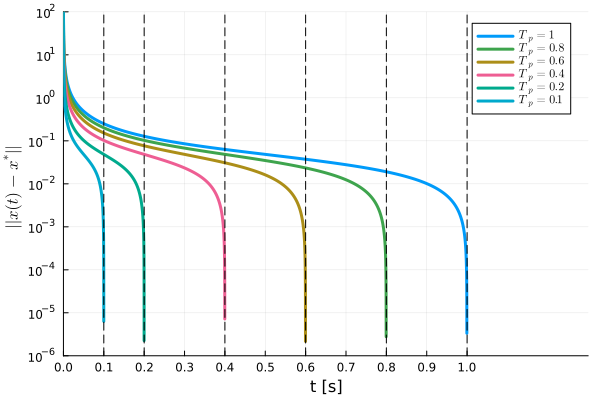

In [4]:
tau_equi_1= sol_1[n+m+1,end]
x_traj_1 = 1/tau_equi_1 .* sol_1[1:n,:]
rel_err_1 = zeros(size(x_traj_1, 2))
for i in 1:size(x_traj_1, 2)
    rel_err_1[i] = norm(x_traj_1[:, i] - x_opt)
end

tau_equi_2 = sol_2[n+m+1,end]
x_traj_2 = 1/tau_equi_2 .* sol_2[1:n,:]
rel_err_2 = zeros(size(x_traj_2, 2))
log_rel_err_2 = zeros(size(x_traj_2, 2))
for i in 1:size(x_traj_2, 2)
    rel_err_2[i] = norm(x_traj_2[:, i] - x_opt)
end

tau_equi_3 = sol_3[n+m+1,end]
x_traj_3 = 1/tau_equi_3 .* sol_3[1:n,:]
rel_err_3 = zeros(size(x_traj_3, 2))
for i in 1:size(x_traj_3, 2)
    rel_err_3[i] = norm(x_traj_3[:, i] - x_opt)
end

tau_equi_4 = sol_4[n+m+1,end]
x_traj_4 = 1/tau_equi_4 .* sol_4[1:n,:]
rel_err_4 = zeros(size(x_traj_4, 2))
for i in 1:size(x_traj_4, 2)
    rel_err_4[i] = norm(x_traj_4[:, i] - x_opt)
end

tau_equi_5 = sol_5[n+m+1,end]
x_traj_5 = 1/tau_equi_5 .* sol_5[1:n,:]
rel_err_5 = zeros(size(x_traj_5, 2))
for i in 1:size(x_traj_5, 2)
    rel_err_5[i] = norm(x_traj_5[:, i] - x_opt)
end

tau_equi_6 = sol_6[n+m+1,end]
x_traj_6 = 1/tau_equi_6 .* sol_6[1:n,:]
rel_err_6 = zeros(size(x_traj_6, 2))
for i in 1:size(x_traj_6, 2)
    rel_err_6[i] = norm(x_traj_6[:, i] - x_opt)
end

plot(sol_1.t, rel_err_1, linewidth=3, yscale=:log10, label=L"$T_p=1$",yticks=[1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1,1e2], xticks=0:0.1:1, xlabel="t [s]", ylabel=L"$\|\|x(t) - x^{*}\|\|$")
vline!([Tp[1]], linestyle=:dash, color=:black, label="")
xlims!(0, 1.3)
ylims!(1e-6,1e2)
plot!(sol_2.t, rel_err_2, linewidth=3, label=L"$T_p=0.8$")
vline!([Tp[2]], linestyle=:dash, color=:black, label="")
plot!(sol_3.t, rel_err_3, linewidth=3, label=L"$T_p=0.6$")
vline!([Tp[3]], linestyle=:dash, color=:black, label="")
plot!(sol_4.t, rel_err_4, linewidth=3, label=L"$T_p=0.4$")
vline!([Tp[4]], linestyle=:dash, color=:black, label="")
plot!(sol_5.t, rel_err_5, linewidth=3,label=L"$T_p=0.2$")
vline!([Tp[5]], linestyle=:dash, color=:black, label="")
plot!(sol_6.t, rel_err_6, linewidth=3, label=L"$T_p=0.1$")
vline!([Tp[6]], linestyle=:dash, color=:black, label="")



In [5]:
savefig("Fig3_QP.pdf")

"/Users/liang/Documents/Julia/AnalogOpti_Code_v1/Fig3_QP.pdf"

In [6]:
Tp = 1.0
k = 2*pi/(4.0*Tp)
Tmax = 0.9999*Tp
p = (Q,c,A,b,n,m,k)

z0 = 5*ones(2*(n+m+1))
dz0 = zeros(2*(n+m+1))
tspan = (0.0, Tmax)
differential_vars = [true for _ in 1:2*(n+m+1)]
Homogeneous_prob = DAEProblem(Homogeneous_ode!, dz0, z0, tspan, p, differential_vars = differential_vars)
t_points = range(tspan[1],tspan[2],length=10000)
# sol_1 = solve(Homogeneous_prob, IDA(), saveat=t_points)
sol_1 = solve(Homogeneous_prob,DFBDF(),saveat=t_points)

z0 = 10*ones(2*(n+m+1))
dz0 = zeros(2*(n+m+1))
tspan = (0.0, Tmax)
differential_vars = [true for _ in 1:2*(n+m+1)]
Homogeneous_prob = DAEProblem(Homogeneous_ode!, dz0, z0, tspan, p, differential_vars = differential_vars)
t_points = range(tspan[1],tspan[2],length=10000)
# sol_2 = solve(Homogeneous_prob, IDA(), saveat=t_points)
sol_2 = solve(Homogeneous_prob,DFBDF(),saveat=t_points)

z0 = 20*ones(2*(n+m+1))
dz0 = zeros(2*(n+m+1))
tspan = (0.0, Tmax)
differential_vars = [true for _ in 1:2*(n+m+1)]
Homogeneous_prob = DAEProblem(Homogeneous_ode!, dz0, z0, tspan, p, differential_vars = differential_vars)
t_points = range(tspan[1],tspan[2],length=10000)
# sol_3 = solve(Homogeneous_prob, IDA(), saveat=t_points)
sol_3 = solve(Homogeneous_prob,DFBDF(),saveat=t_points)

z0 = 40*ones(2*(n+m+1))
dz0 = zeros(2*(n+m+1))
tspan = (0.0, Tmax)
differential_vars = [true for _ in 1:2*(n+m+1)]
Homogeneous_prob = DAEProblem(Homogeneous_ode!, dz0, z0, tspan, p, differential_vars = differential_vars)
t_points = range(tspan[1],tspan[2],length=10000)
# sol_4 = solve(Homogeneous_prob, IDA(), saveat=t_points)
sol_4 = solve(Homogeneous_prob,DFBDF(),saveat=t_points)

z0 = 60*ones(2*(n+m+1))
dz0 = zeros(2*(n+m+1))
tspan = (0.0, Tmax)
differential_vars = [true for _ in 1:2*(n+m+1)]
Homogeneous_prob = DAEProblem(Homogeneous_ode!, dz0, z0, tspan, p, differential_vars = differential_vars)
t_points = range(tspan[1],tspan[2],length=10000)
# sol_5 = solve(Homogeneous_prob, IDA(), saveat=t_points)
sol_5 = solve(Homogeneous_prob,DFBDF(),saveat=t_points)

z0 = 80*ones(2*(n+m+1))
dz0 = zeros(2*(n+m+1))
tspan = (0.0, Tmax)
differential_vars = [true for _ in 1:2*(n+m+1)]
Homogeneous_prob = DAEProblem(Homogeneous_ode!, dz0, z0, tspan, p, differential_vars = differential_vars)
t_points = range(tspan[1],tspan[2],length=10000)
# sol_6 = solve(Homogeneous_prob, IDA(), saveat=t_points);
sol_6 = solve(Homogeneous_prob,DFBDF(),saveat=t_points);

┌ Warning: At t=0.9994303643479785, dt was forced below floating point epsilon 1.1102230246251565e-16, and step error estimate = 0.033721490581882035. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase /Users/liang/.julia/packages/SciMLBase/jadet/src/integrator_interface.jl:623
┌ Warning: At t=0.9997995694547881, dt was forced below floating point epsilon 1.1102230246251565e-16, and step error estimate = 0.052192016646453905. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase /Users/liang/.julia/packages/SciMLBase/jadet/src/integrator_interface.jl:623
┌ Warning: At t=0.9995690395930966, dt was forced below floating point epsilon 1.1102230246251565e-16, and step error estimate = 0.002662173645700068. Aborting. There is eith

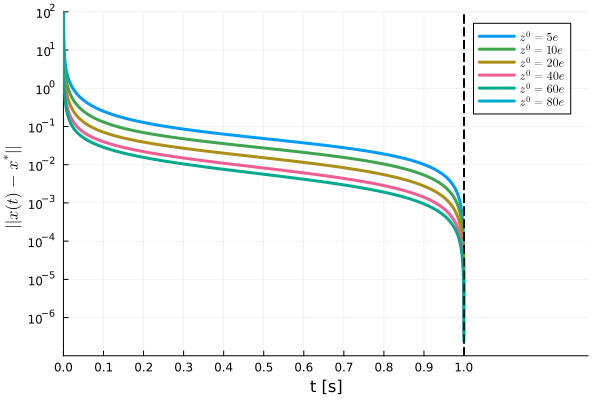

In [7]:
tau_equi_1= sol_1[n+m+1,end]
x_traj_1 = 1/tau_equi_1 .* sol_1[1:n,:]
rel_err_1 = zeros(size(x_traj_1, 2))
for i in 1:size(x_traj_1, 2)
    rel_err_1[i] = norm(x_traj_1[:, i] - x_opt)
end

tau_equi_2 = sol_2[n+m+1,end]
x_traj_2 = 1/tau_equi_2 .* sol_2[1:n,:]
rel_err_2 = zeros(size(x_traj_2, 2))
log_rel_err_2 = zeros(size(x_traj_2, 2))
for i in 1:size(x_traj_2, 2)
    rel_err_2[i] = norm(x_traj_2[:, i] - x_opt)
end

tau_equi_3 = sol_3[n+m+1,end]
x_traj_3 = 1/tau_equi_3 .* sol_3[1:n,:]
rel_err_3 = zeros(size(x_traj_3, 2))
for i in 1:size(x_traj_3, 2)
    rel_err_3[i] = norm(x_traj_3[:, i] - x_opt)
end

tau_equi_4 = sol_4[n+m+1,end]
x_traj_4 = 1/tau_equi_4 .* sol_4[1:n,:]
rel_err_4 = zeros(size(x_traj_4, 2))
for i in 1:size(x_traj_4, 2)
    rel_err_4[i] = norm(x_traj_4[:, i] - x_opt)
end

tau_equi_5 = sol_5[n+m+1,end]
x_traj_5 = 1/tau_equi_5 .* sol_5[1:n,:]
rel_err_5 = zeros(size(x_traj_5, 2))
for i in 1:size(x_traj_5, 2)
    rel_err_5[i] = norm(x_traj_5[:, i] - x_opt)
end

tau_equi_6 = sol_6[n+m+1,end]
x_traj_6 = 1/tau_equi_6 .* sol_6[1:n,:]
rel_err_6 = zeros(size(x_traj_6, 2))
for i in 1:size(x_traj_6, 2)
    rel_err_6[i] = norm(x_traj_6[:, i] - x_opt)
end
plot(sol_1.t, rel_err_1, label=L"$z^0=5e$", linewidth=3, yscale=:log10, yticks=[1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1,1e2],xticks=0:0.1:1, xlabel="t [s]", ylabel=L"$\|\|x(t) - x^{*}\|\|$", legend=:topright)
vline!([Tp], linestyle=:dash, color=:black, label="")
xlims!(0, 1.31)
ylims!(1e-7,1e2)
plot!(sol_2.t, rel_err_2, label=L"$z^0=10e$", linewidth=3)
vline!([Tp], linestyle=:dash, color=:black, label="")
plot!(sol_3.t, rel_err_3, label=L"$z^0=20e$", linewidth=3)
vline!([Tp], linestyle=:dash, color=:black, label="")
plot!(sol_4.t, rel_err_4, label=L"$z^0=40e$", linewidth=3)
vline!([Tp], linestyle=:dash, color=:black, label="")
plot!(sol_5.t, rel_err_5, label=L"$z^0=60e$", linewidth=3)
vline!([Tp], linestyle=:dash, color=:black, label="")
plot!(sol_6.t, rel_err_6, label=L"$z^0=80e$", linewidth=3)
vline!([Tp], linestyle=:dash, color=:black, label="")



In [8]:
savefig("Fig4_QP.pdf")

"/Users/liang/Documents/Julia/AnalogOpti_Code_v1/Fig4_QP.pdf"